In [21]:
import torch
from torchaudio.datasets import SPEECHCOMMANDS
import os
import torchaudio
from os.path import join
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
from math import log2
import numpy as np
from tqdm import tqdm
from multiprocess import Pool
import functools
import shutil

## Load Data (Google Speech Commands V2)

In [2]:
# modified version of 
#.  https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(map(os.path.abspath, excludes))
            self._walker = [w for w in self._walker if os.path.abspath(w) not in excludes]
    
    def __getitem__(self, idx):
      fname = self._walker[idx]
      x = torchaudio.load(fname)[0]
      split = fname.split("/")
      word = split[-2]
      id = split[-1].rstrip(".wav")
      return (x, word, id)

In [3]:
train = SubsetSC("training")
val = SubsetSC("validation")
test = SubsetSC("testing")
print(len(train), len(val), len(test))

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

84843 9981 11005


In [4]:
idx = 0
word_index = {}
for dat in train:
  word = dat[1]
  if word not in word_index:
    word_index[word] = idx
    idx += 1
print("Num labels:", len(word_index.keys()))
print(word_index.keys())

Num labels: 35
dict_keys(['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'])


### Process Data

In [5]:
fmin = 100
fmax = 6000
bins = 50
hop_length = 64
bins_per_octave = int(bins / log2(fmax/fmin) + 0.5)
print(f"Creating constant-q filter with {bins_per_octave} bins per octave")

Creating constant-q filter with 8 bins per octave


In [6]:
def normalize(X):
  # min-max
  d = X.max() - X.min()
  eps = 1e-4
  return (X - X.min()) / (d + eps)

In [7]:
def transform(data):
  x, word, id = data
  x = x.flatten().numpy()
  X = librosa.cqt(x, sr=16000, hop_length=hop_length, fmin=fmin, n_bins=bins, bins_per_octave=bins_per_octave)
  X = torch.tensor(X[np.newaxis]).abs()
  X = normalize(X)
  return x, X, word, id

In [8]:
idx = 8000
x = train[idx]
Audio(x[0][0].numpy(), rate=16000)

4


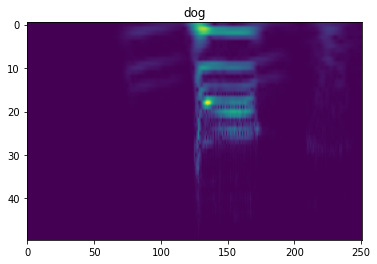

In [9]:
transformed = transform(x)
X = transformed[1][0]
word = transformed[2]
plt.title(word)
plt.imshow(X, aspect="auto")
print(word_index[word])

In [29]:
def transform_and_save(dirname, dat):
  x, X, word, id = transform(dat)
  label = word_index[word]
  item = (X, label)
  path = join(dirname, word, id + ".pt")
  torch.save(item, path)

In [32]:
def save_data(dataset, dirname, num_workers=4):
  for word in word_index.keys():
    word_dir = join(dirname, word)
    os.makedirs(word_dir, exist_ok=True)
  shutil.rmtree(dirname, ignore_errors=True)
  pool = Pool(num_workers)
  func = functools.partial(transform_and_save, dirname)
  t = tqdm(
    pool.imap_unordered(func, dataset),
    total=len(dataset),
    leave=False
  )
  count = 0
  for _ in t:
    count += 1

In [33]:
dataset_dir = "processed"
save_data(train, join(dataset_dir, "train"))
save_data(val, join(dataset_dir, "val"))
save_data(test, join(dataset_dir, "test"))



  0%|          | 0/84843 [00:00<?, ?it/s]

  0%|          | 1/84843 [00:01<39:17:06,  1.67s/it]

  0%|          | 4/84843 [00:01<8:36:15,  2.74it/s] 

  0%|          | 5/84843 [00:03<15:46:54,  1.49it/s]

  0%|          | 8/84843 [00:03<8:00:55,  2.94it/s] 

  0%|          | 9/84843 [00:04<13:11:33,  1.79it/s]

  0%|          | 12/84843 [00:05<7:58:00,  2.96it/s]

  0%|          | 13/84843 [00:06<12:07:26,  1.94it/s]

  0%|          | 14/84843 [00:06<10:09:23,  2.32it/s]

  0%|          | 16/84843 [00:06<7:22:17,  3.20it/s] 

  0%|          | 17/84843 [00:08<12:31:42,  1.88it/s]

  0%|          | 18/84843 [00:08<10:26:51,  2.26it/s]

  0%|          | 20/84843 [00:08<7:16:25,  3.24it/s] 

  0%|          | 21/84843 [00:09<12:34:20,  1.87it/s]

  0%|          | 22/84843 [00:09<10:22:03,  2.27it/s]

  0%|          | 24/84843 [00:10<7:06:41,  3.31it/s] 

  0%|          | 25/84843 [00:11<12:30:28,  1.88it/s]

  0%|          | 26/84843 [00:11<10:05:59,  2.33it/s]

  0%|          | 28/84843 

KeyboardInterrupt: ignored

In [ ]:
path = join(dataset_dir, "word_indices.txt")
with open(path, "w") as f:
  f.writelines(" ".join(pair) for pair in word_index.items())